# Probability Distributions


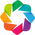

In [1]:
import numpy as np
import pandas as pd
import holoviews as hv

import scipy.stats as st

hv.extension("bokeh")

## Fancy counting: binomial

## Fancy counting 2: multinomial

## Average of a weird distribution

Let's make a function that draws random numbers from a weird complicated distribution.

In [2]:
def draw_whatever():
    subdist = np.random.choice(["a", "b", "c", "d"])
    if subdist == "a":
        return np.random.normal(np.random.choice([1,2,3]), 0.15)
    elif subdist == "b":
        return np.random.exponential(3)-5
    else:
        return np.random.choice([-1,1])*np.sqrt(np.random.uniform(0,15))

In [3]:
samples = [draw_whatever() for _ in range(10000)]

In [4]:
%%opts Histogram [width=600 height=400]
hist = hv.Histogram(*np.histogram(samples, 150)).redim.label(x='sampled value')
hist

:Histogram   [x]   (Frequency)

In [5]:
sample_means = [
    np.mean([draw_whatever() for _ in range(1000)]) for i in range(1000)
]

In [6]:
mu = np.mean(sample_means)
scale = np.std(sample_means)

In [7]:
%%opts Histogram [width=600 height=400]
hist = hv.Histogram(*np.histogram(sample_means, 25)).redim.label(x="mean of samples")
hist

:Histogram   [x]   (Frequency)

In [8]:
xvals = np.linspace(-0.3, 0.3, 100)
theory = st.norm.pdf(xvals, loc=mu, scale=scale)

In [9]:
%%opts Curve (color="firebrick" line_width=4)
curve = hv.Curve((xvals, theory*100/theory.max()))

In [10]:
hist*curve

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .Curve.I     :Curve   [x]   (y)

## Point Process data

What kind of patterns will we see in data without any patterns in it?

In [11]:
N = 5000
points = pd.DataFrame({"x":np.random.uniform(0,1,N), "y":np.random.uniform(0,1,N)})
points.head()

,x,y
0,0.943750,0.937252
1,0.894011,0.463692
2,0.742238,0.202135
3,0.364880,0.296896
4,0.803750,0.216514


In [12]:
hv.Scatter(points)

:Scatter   [x]   (y)

In [13]:
points["box"] = ((points.x // 0.02) + 50*(points.y // 0.02)).astype(int)
points.head()

,x,y,box
0,0.943750,0.937252,2347
1,0.894011,0.463692,1194
2,0.742238,0.202135,537
3,0.364880,0.296896,718
4,0.803750,0.216514,540


In [14]:
boxcounts = np.array([np.sum(points.box == i) for i in range(2500)])

In [15]:
print(boxcounts.mean())
print(boxcounts.var())

2.0
2.084


In [16]:
%%opts Histogram [width=700 tools=["hover"]]
hist = hv.Histogram(*np.histogram(boxcounts, np.arange(0,15)-0.5)).redim.label(x="counts per box")
hist

:Histogram   [x]   (Frequency)

In [17]:
xvals = range(15)
poisson_counts = st.poisson.pmf(xvals, mu=boxcounts.mean())
theory = pd.DataFrame({"x":xvals, "y":2500*poisson_counts})

In [18]:
scatter = hv.Scatter(theory)

In [19]:
%%opts Scatter (size=10 color="firebrick")
hist * scatter

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .Scatter.I   :Scatter   [x]   (y)

In [20]:
xpoints = points.x.values.copy()
xpoints.sort()

In [21]:
point_distances = xpoints[1:] - xpoints[:-1]
point_distances[:10]

array([  3.75426447e-05,   3.51314917e-04,   5.13551011e-05,
         2.33004384e-04,   1.75201297e-04,   3.09249597e-04,
         4.22670587e-05,   4.52075671e-05,   2.63810462e-04,
         1.70608633e-04])

In [22]:
%%opts Histogram [width=700 tools=["hover"]]
disthist = hv.Histogram(*np.histogram(point_distances,25)).redim.label(x="distance between points")
disthist

:Histogram   [x]   (Frequency)

In [23]:
theoryhist = hv.Histogram(*np.histogram(np.random.exponential(point_distances.mean(), 5000), 25))

In [24]:
%%opts Histogram [width=700 tools=["hover"]] (alpha=0.5)
disthist * theoryhist

:Overlay
   .Histogram.I  :Histogram   [x]   (Frequency)
   .Histogram.II :Histogram   [x]   (Frequency)

## Preferential Attachment

Let's generate data from a simple model. Say we have 1000 buckets. Every iteration, we'll randomly choose a bucket to add a ball to- but we'll choose the bucket with a probability (roughly) proportional to the number of balls currently in it.

In [130]:
N = 10000
buckets = np.ones(N)/10

In [131]:
for i in range(100000):
    buckets[np.random.choice(np.arange(N), p=buckets/buckets.sum())] += 1

In [132]:
buckets.max()

810.10000000000002

In [133]:
freqs, bins = np.histogram(buckets, np.ceil(buckets.max()))

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


In [134]:
pa_hist = hv.Histogram(freqs, bins)
pa_hist

:Histogram   [x]   (Frequency)

The pattern in this histogram is much easier to see if we look at both axes on logarithmic scales:

In [135]:
%%opts Scatter [logy=True logx=True]
hv.Scatter((bins[1:], freqs+1))

:Scatter   [x]   (y)

Where do we have to look out for this kind of scale invariant behavior?

* Ratios of random variables
* Systems exhibiting preferential attachment
* Systems exhibiting self-organized criticality